#  Biodiversity Intactness Index change in Phoenix, AZ

Using Biodiversity Intactness Index (BII) from the Microsoft Planetary Computer STAC catalog and Phoenix Subdivision Shapefile to measure changes in biodiversity in Phoenix, Arizona

Author: Michelle Yiv

For further information and content about this analysis, view this [GitHub repository.](https://github.com/mmyiv/Changes-in-Biodiversity-Intactness-in-Arizona)


![Arizona Landscape. Source: azsustainabilityalliance.com](https://i0.wp.com/www.azsustainabilityalliance.com/wp-content/uploads/2019/05/Arizona_Biodiversity.jpeg?resize=1170%2C777&ssl=1)


#### Purpose


#### Datasets used

**1. California Fire Perimeter**

California fire perimeter was published by [CAL FIRE]((https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436)) and contains information about fires in California. In addition to the geometries (perimeters) of each fire, there is information about the name, date, and acres burned.

**2. Landsat data** 

Landsat was published by [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) and contains both x,y coordinates and variables containing colors (R, G, B, NIR, SWIR) for plotting. This dataset contains the Santa Barbara location and surrounding areas. 


#### Analysis Highlights



#### References to datasets
Microsoft Planetary Computer. Biodiversity Intactness. [Dataset]. Microsoft. Retrieved December 5, 2024, from https://planetarycomputer.microsoft.com/dataset/io-biodiversity

Census Bureau, TIGER/Line Shapefiles. Census.Gov. 2024 County Subdivison Shapefile. [Dataset]. United States Census Bureau. Retrieved December 5, 2024, from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html



AuthorLastName, AuthorFirstInitial OR Organization. (Year). Title of dataset (Version number) [Dataset]. Publisher. DOI or URL


## Set up

### Import packages

In [50]:
# Import packages

import numpy as np
import geopandas as gpd
import os

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

import rioxarray as rioxr
from shapely import box

import pystac_client
import planetary_computer

from IPython.display import Image
import contextily as cx

### Read in data

In [2]:
# Read in shapefile for Arizona
fp = os.path.join('data','tl_2024_04_cousub.shp')
county = gpd.read_file(fp)

# Filter to Phoenix county subdivision
ph = county[county['NAME'] == 'Phoenix']

In [3]:
# Access data from MPC
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
# Set time range
time_range = "2017-01-01/2020-01-01"

# Set bbox according to course website
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Catalog search
search = catalog.search(
    collections=["io-biodiversity"], 
    bbox=bbox, 
    datetime = time_range)

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 4 Items


## Map of Phoenix Subdivision

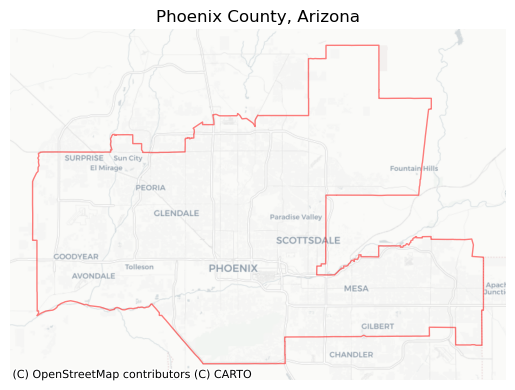

In [5]:
# Initialize plot
fig, ax = plt.subplots()

# Plot Phoenix, AZ County border
(ph.to_crs(epsg=3857).plot(ax=ax, 
                           edgecolor="red", 
                           facecolor='none',
                           alpha = 0.5, 
                           figsize=(9, 9)))

# Add basemap from contextily
cx.add_basemap(ax=ax, source = cx.providers.CartoDB.Positron)

# Add title and turn off axis
ax.set_title("Phoenix County, Arizona")
ax.set_axis_off()

plt.show()

### BII Analysis

#### 2017

In [6]:
# Get first item in the catalog search - 2017
item = items[3]

In [7]:
# Access raster data from item
bio_2017 = rioxr.open_rasterio(item.assets['data'].href)
bio_2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [8]:
# Remove length 1 dimension (band)
bio_2017 = bio_2017.squeeze().drop_vars('band')

In [9]:
# Match CRSs and verify update
ph_match = ph.to_crs(bio_2017.rio.crs)

assert bio_2017.rio.crs == ph_match.crs

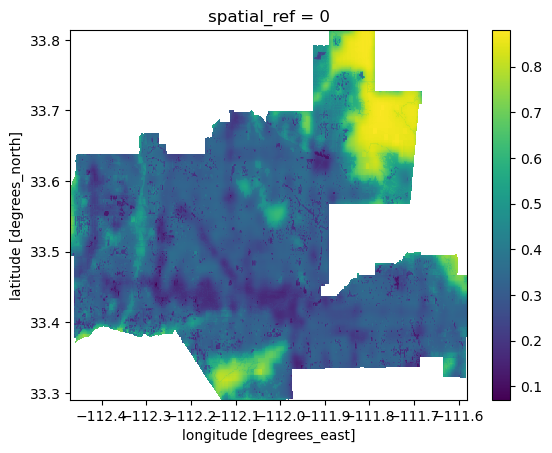

In [10]:
# Clip raster to match Phoenix 
bio_2017_clip = (bio_2017.rio.clip_box(*ph_match.total_bounds)
                 .rio.clip(ph_match.geometry))
# View
bio_2017_clip.plot()

#### 2020

In [11]:
# Get first item in the catalog search - 2020
item2 = items[0]

In [12]:
# Access raster data from item
bio_2020 = rioxr.open_rasterio(item2.assets['data'].href)
bio_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [13]:
# Remove length 1 dimension (band)
bio_2020 = bio_2020.squeeze().drop_vars('band')

In [15]:
# Match CRSs and verify update
ph_match = ph.to_crs(bio_2020.rio.crs)

assert bio_2020.rio.crs == ph_match.crs

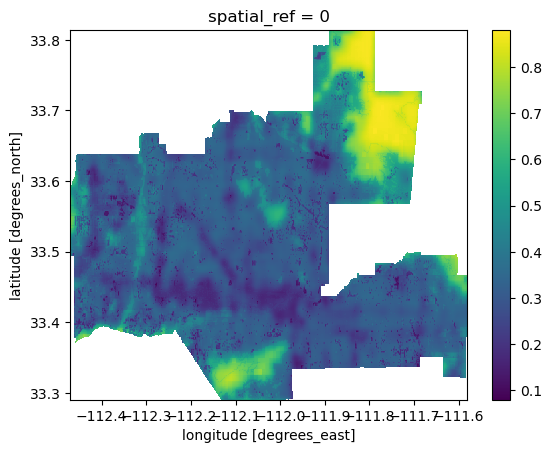

In [16]:
# Clip raster to match Phoenix 
bio_2020_clip = (bio_2020.rio.clip_box(*ph_match.total_bounds)
                         .rio.clip(ph_match.geometry))
# View
bio_2020_clip.plot()

## Calculating the difference in percentage of BII area >0.75 between 2017 and 2020

#### Calculate percentage area for 2017

In [17]:
# Identify BII values greater than 0.75 for both years
bio_2017_bii = (bio_2017_clip >= 0.75).astype(int)

In [21]:
# Find total number of pixels
total_2017 = bio_2017_clip.count().item()

# Find pixels with bii > 0.75
values_2017 = bio_2017_bii.sum().item() # sum() adds pixels that are >0.75

# Calculate percentage (part/whole)
pct_2017 = round((values_2017/total_2017) * 100, 2)

print("The percentage of Phoenix subdivision with a BII >= 0.75 in 2017 is ", round(pct_2017, 2), "%")

The percentage of Phoenix subdivision with a BII >= 0.75 in 2017 is  7.13 %


#### Calculate percentage area for 2020

In [19]:
# Identify BII values greater than 0.75 for 2020
bio_2020_bii = (bio_2020_clip >= 0.75).astype(int)

In [22]:
# Find total number of pixels
total_2020 = bio_2020_clip.count().item()

# Find pixels with bii > 0.75
values_2020 = bio_2020_bii.sum().item() # sum() adds pixels that are >0.75

# Calculate percentage (part/whole)
pct_2020 = (values_2020 / total_2020) * 100

print("The percentage of Phoenix subdivision with a BII >= 0.75 in 2020 is ", round(pct_2020, 2), "%")

The percentage of Phoenix subdivision with a BII >= 0.75 in 2020 is  6.49 %


#### Visualize BII loss

In [32]:
# Calculate loss from 2017 to 2020
pct_diff = bio_2017_bii - bio_2020_bii

To visualize the loss, refer to diagram from course website

![Raster Difference. Source: EDS220 Course Website](https://meds-eds-220.github.io/MEDS-eds-220-course/assignments/images/bii_raster_math.png)

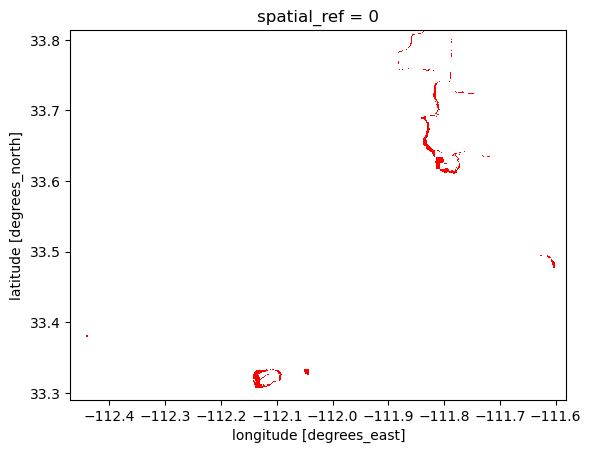

In [43]:
# Have BII >0.75 in 2017 set to 1 as it represents bii loss
bii_loss = pct_diff == 1

# Convert to integer to actually be able to plot
bii_loss = bii_loss.astype(int)

# Apply cmap to plot

# Make dictionary of colors
colors = {
    0: "none",        # No Data
    1: "red",         # Bii loss 
}
    
# Create a ListedColormap
cmap = ListedColormap([colors[key] for key in sorted(colors.keys())])

# View updated inital plot
bii_loss.plot(cmap = cmap, add_colorbar = False)   

In [ ]:
# Initialize plot
fig, ax = plt.subplots(figsize = (9,9))

# Add Phoenix, AZ basemap from step 1
ph.plot(ax=ax,
       edgecolor = 'black',
       linewidth = 4)

# Add 2020 biodiversity as base layer
bio_2020_clip.plot(ax = ax,
                  cbar_kwargs = {"location": "bottom",
                                 "label": "2020 BII"})
# Add BII difference (from above)
bii_loss.plot(ax = ax,
              cmap = cmap, 
              add_colorbar = False)  

# Add legend
custom_legend = Line2D([0], [0], color='red', lw=3, label='Area of BII Loss >= 75% (2017-2020)')  # Change color and line style as needed

# Add the legend
ax.legend(handles=[custom_legend], loc='upper left', fontsize=10)

# Turn off axis
ax.set_axis_off()

# Set title
ax.set_title("Change in Biodiversity Intactness Index From 2017 to 2020 in Phoenix County, Arizona")

plt.show()